In [1]:
using Revise

In [83]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting

In [84]:
using BenchmarkTools

In [85]:
using Interpolations

In [86]:
using PyPlot

In [87]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 10;

In [88]:
base_params = deepcopy(ClimateMARGO.IO.included_configurations["default"])
q = deepcopy(base_params.economics.baseline_emissions);
itp = interpolate((t(base_params),), q, Gridded(Linear()));

In [89]:
function opt_benchmark(m)
    optimize_controls!(m)
    return nothing
end

opt_benchmark (generic function with 1 method)

In [90]:
m_pre = ClimateModel(base_params)
@elapsed T(m_pre);
@elapsed opt_benchmark(m_pre);

Solve_Succeeded


In [91]:
dts = [0.05, 0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 30.]

runtimes = Array{Float64}(undef, size(dts,1));
optimize_runtimes = Array{Float64}(undef, size(dts,1));
solutions = Array{ClimateModel}(undef, size(dts,1));

for (i, dt) = enumerate(dts)
    print(i, ", ")
    params = deepcopy(base_params)
    params.domain.dt = dt
    params.economics.baseline_emissions = itp(t(params));
    m = ClimateModel(params)
    
    T_bench() = T(m)
    function opt_bench()
        optimize_controls!(m, print_raw_status=false)
        return
    end
    
    runtimes[i] = @belapsed $T_bench();
    optimize_runtimes[i] = @belapsed $opt_bench();
    
    solutions[i] = deepcopy(m)
end

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

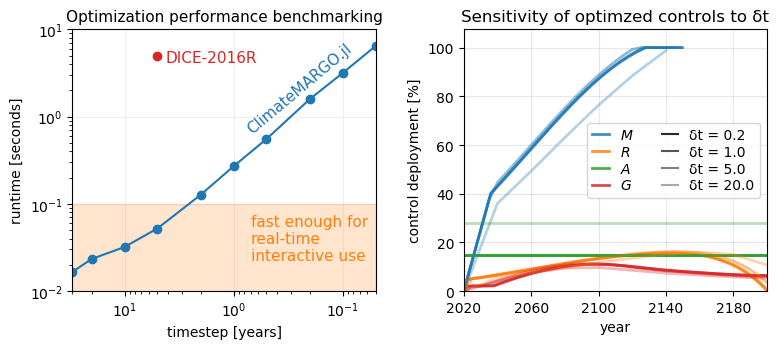

0.8333333333333334 0.6666666666666666 0.5 0.3333333333333333 

In [380]:
figure(figsize=(8,3.6))

subplot(1,2,1)
title("Optimization performance benchmarking", fontsize=11)
loglog(dts, optimize_runtimes, "C0o-")
annotate("ClimateMARGO.jl", (0.8e0, 0.65), color="C0", rotation=40, fontsize=11)

fill_between(xlims, [ylims[1], ylims[1]], [0.1, 0.1], color="C1", alpha=0.2)
annotate("fast enough for\nreal-time\ninteractive use", (0.7, 0.0225), color="C1", fontsize=11)

grid(true, alpha=0.2)
plot([5.], [5.], "C3o")
annotate("DICE-2016R", (5. -0.75, 5. - 0.725), color="C3", fontsize=11)
xlims = xlim(dts[end], dts[1])
ylims = ylim(1e-2, 1e1)
xlabel("timestep [years]")
ylabel("runtime [seconds]")
savefig("figures/benchmarking.png", dpi=150., bbox_inches="tight")

subplot(1,2,2)
skip_idx = 3:2:length(solutions)
for (i, m) = enumerate(solutions[skip_idx])
    title("Sensitivity of optimzed controls to δt")
    alpha = (1.5 - i/length(solutions[skip_idx]))/1.5
    print(alpha, " ")
    if i==1
        plot(t(m)[m.economics.baseline_emissions .> 0.], m.controls.mitigate[m.economics.baseline_emissions .> 0.],
            color="C0", lw=2, label=L"$M$", alpha=alpha)
        plot(t(m), m.controls.remove, color="C1", lw=2, label=L"$R$", alpha=alpha)
        plot(t(m), m.controls.adapt, color="C2", lw=2, label=L"$A$", alpha=alpha)
        plot(t(m), m.controls.geoeng, color="C3", lw=2, label=L"$G$", alpha=alpha)
    else
        plot(t(m)[m.economics.baseline_emissions .> 0.], m.controls.mitigate[m.economics.baseline_emissions .> 0.],
            color="C0", lw=2, label=nothing, alpha=alpha)
        plot(t(m), m.controls.remove, color="C1", lw=2, label=nothing, alpha=alpha)
        plot(t(m), m.controls.adapt, color="C2", lw=2, label=nothing, alpha=alpha)
        plot(t(m), m.controls.geoeng, color="C3", lw=2, label=nothing, alpha=alpha)
    end
    plot([], [], "k-", alpha=alpha, label=string("δt = ", dts[skip_idx][i]))
    ylims = [0., 1.075]
    yticks(0.:0.2:1.0, 0:20:100)
    ylim(ylims)
    ylabel("control deployment [%]")
    xlabel("year")
    xlim(t(m)[1],2200.)
    xticks(t(m)[1]:40.:2200.)
    grid(true, alpha=0.3)
end
legend(ncol=2, handlelength=1.2, labelspacing=0.2)
tight_layout()
savefig("figures/performance.png")
